In [3]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from scipy import stats

sys.path.append('...')  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [4]:
# import "tesla_driving_temp_data.csv"
df = pd.read_csv('tesla_driving_temp_data.csv')

In [5]:
#[power, speed, battery_level, outside_temp] => [battery_temperature]
#[power, speed, battery_level, outside_temp, battery_temperature] => [delta_battery_temperature]

In [6]:
# Interpolate the missing data
df['outside_temp'] = df['outside_temp'].interpolate()
df['speed'] = df['speed'].interpolate()

In [7]:
# Compute deltaTemp and add an additional column to dataset
df['deltaTemp'] = df['battery_temperature'].diff(periods=-1)*(-1)

In [8]:
#Interpolate deltaTemp
df['deltaTemp'] = df['deltaTemp'].interpolate()

In [10]:
#Remove transition points between different drives/dates
idx=(df['drive_id'].diff()[df['drive_id'].diff() != 0].index.values)
idx=idx-1
df = df.drop(idx[1:])


In [12]:
# Remove values larger than 0.1
remove=(df['deltaTemp'][np.abs(df['deltaTemp']) >= 0.1].index.values)
df = df.drop(remove)


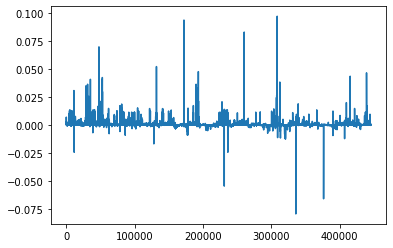

In [13]:
plt.plot(df[["deltaTemp"]], '-')

In [15]:
# Separate data to trainining and test data

np.random.seed(10)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]


In [16]:
# Extract features and labels for training dataset
#df_x = train[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
#df_y = train[["deltaTemp"]]
#print(df_y.shape)

In [17]:
# Extract features and labels for all dataset
df_x = df[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
df_y = df[["deltaTemp"]]

df_x_tensor = (torch.tensor(df_x.values)).float()
df_y_tensor = torch.tensor(df_y.values).float()


In [18]:
#MLP
lb = torch.min(df_x_tensor,0).values.numpy()
ub = torch.max(df_x_tensor,0).values.numpy()

model = pf.models.MLP(input_size=5,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)

model.cuda() #GPU

In [19]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

Epoch  0 Loss  0.048398829996585846
Epoch  1 Loss  0.054860375821590424
Epoch  2 Loss  0.021476346999406815
Epoch  3 Loss  0.022579876706004143
Epoch  4 Loss  0.0274522565305233
Epoch  5 Loss  0.01493208296597004
Epoch  6 Loss  0.0042273178696632385
Epoch  7 Loss  0.004640922881662846
Epoch  8 Loss  0.009752213023602962
Epoch  9 Loss  0.011783238500356674
Epoch  10 Loss  0.009734614752233028
Epoch  11 Loss  0.006436943542212248
Epoch  12 Loss  0.004012596793472767
Epoch  13 Loss  0.0027126942295581102
Epoch  14 Loss  0.0020954255014657974
Epoch  15 Loss  0.0020404106471687555
Epoch  16 Loss  0.002575407736003399
Epoch  17 Loss  0.003342428244650364
Epoch  18 Loss  0.003690253710374236
Epoch  19 Loss  0.0032630381174385548
Epoch  20 Loss  0.0023024859838187695
Epoch  21 Loss  0.001387947122566402
Epoch  22 Loss  0.0009410583297722042
Epoch  23 Loss  0.0009381365962326527
Epoch  24 Loss  0.001041186973452568
Epoch  25 Loss  0.0009755021892488003
Epoch  26 Loss  0.0007658019894734025
Epoc

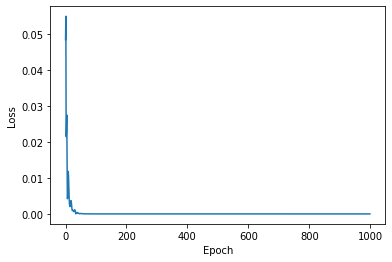

In [20]:
x_data_plot=[]
y_data_plot=[]
for epoch in range(1000):
    optimizer.zero_grad()
    prediction = model(df_x_tensor.cuda()) #GPU
    #prediction = model(df_x_tensor) #CPU
    loss = criterion(prediction,df_y_tensor.cuda())  #GPU
    #loss = criterion(prediction,df_y_tensor) #CPU
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "Loss ", loss.item())
    x_data_plot.append(epoch)
    y_data_plot.append(loss.item())

# Make the plot of all the points together
plt.plot(x_data_plot,y_data_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.show()

In [21]:
# Test data
#df_x = test[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
#df_y = test[["deltaTemp"]]
#df_x_tensor = (torch.tensor(df_x.values)).float()
#df_y_tensor = torch.tensor(df_y.values).float()

In [22]:
# Make prediction
df_x_tensor=df_x_tensor
pred = model(df_x_tensor.float().cuda()) #GPU
#pred = model(df_x_tensor.float())

##pred = model(Tensor(X_star).cpu())
pred = pred.detach().cpu().numpy()

In [23]:
df_y_tensor_np = df_y_tensor.numpy()

#comb = np.concatenate([df_y_tensor_np, pred],axis = 1)
#print(np.concatenate([df_y_tensor_np, pred],axis = 1))

print('relative l2 error:',(np.linalg.norm(df_y_tensor_np-pred)) / (np.linalg.norm(df_y_tensor_np)))

relative l2 error: 1.3320295


In [24]:
from torch.nn import L1Loss, MSELoss

loss1 = MSELoss()
loss2 = L1Loss()
input = torch.from_numpy(pred)
target = df_y_tensor
MSE = loss1(input, target)
MAE = loss2(input, target)
print('MSE:', MSE)
print('MAE:', MAE)

MSE: tensor(7.7592e-07)
MAE: tensor(0.0005)


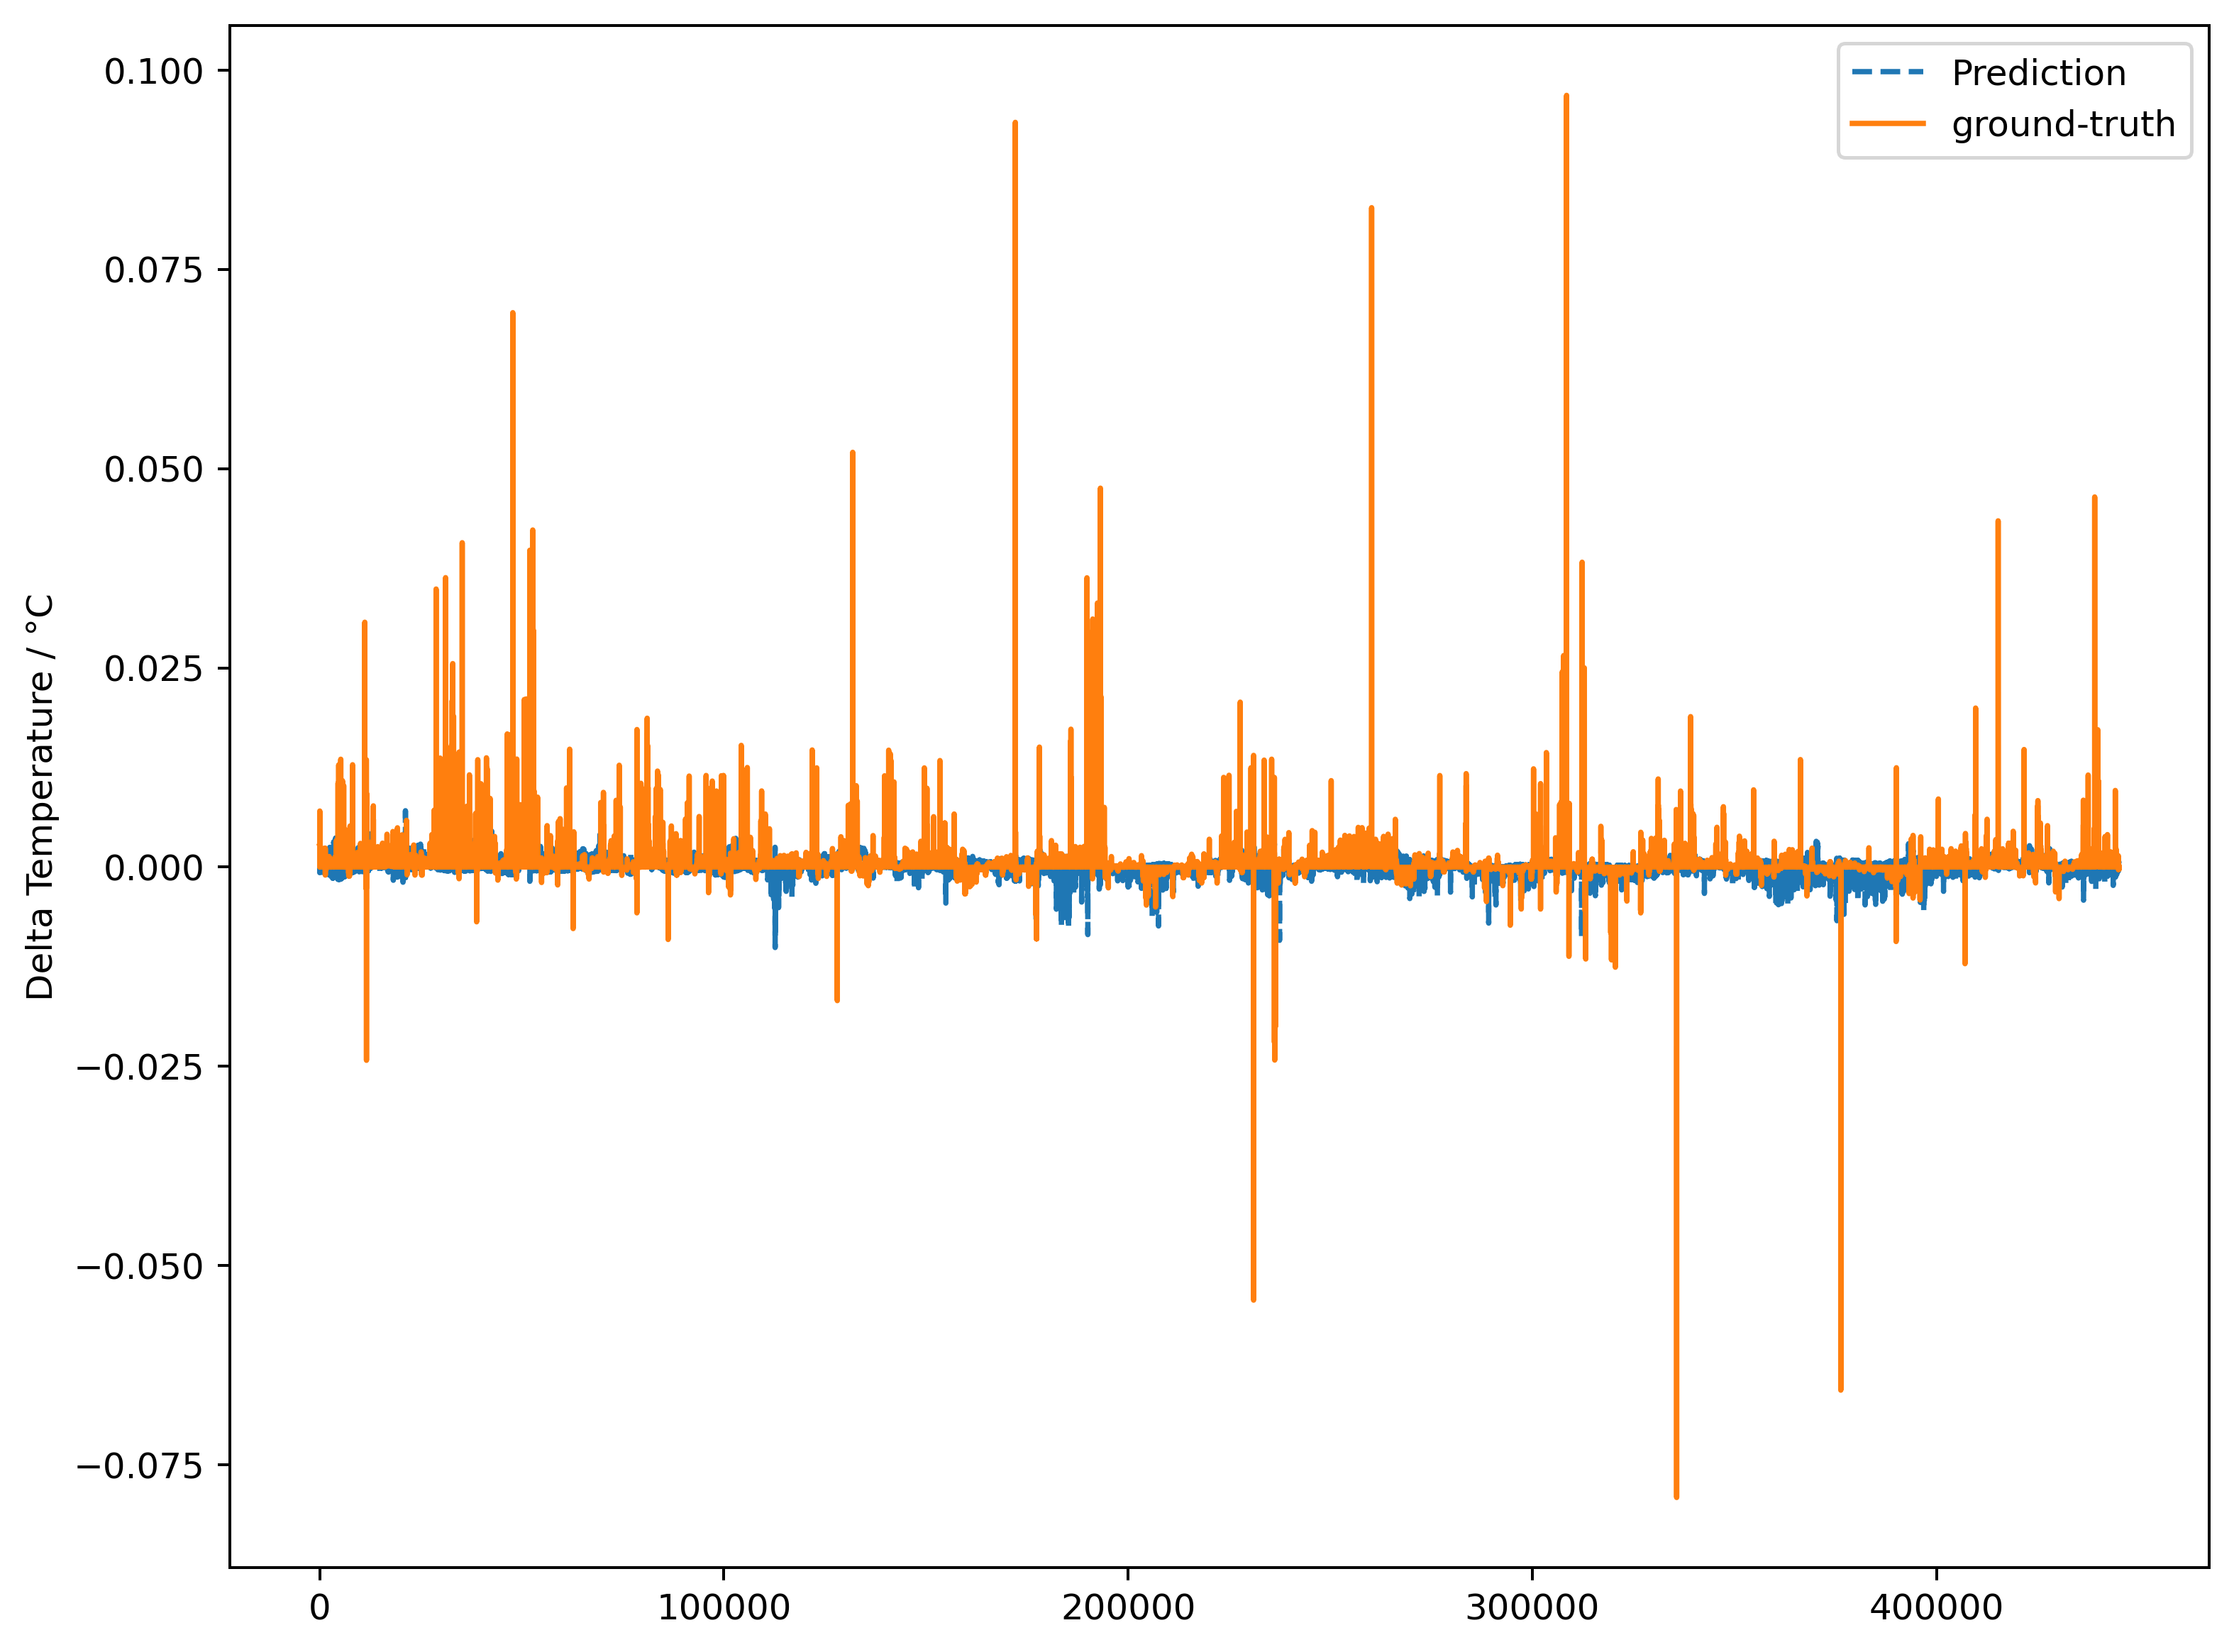

In [25]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([0, 0.01])
plt.show()

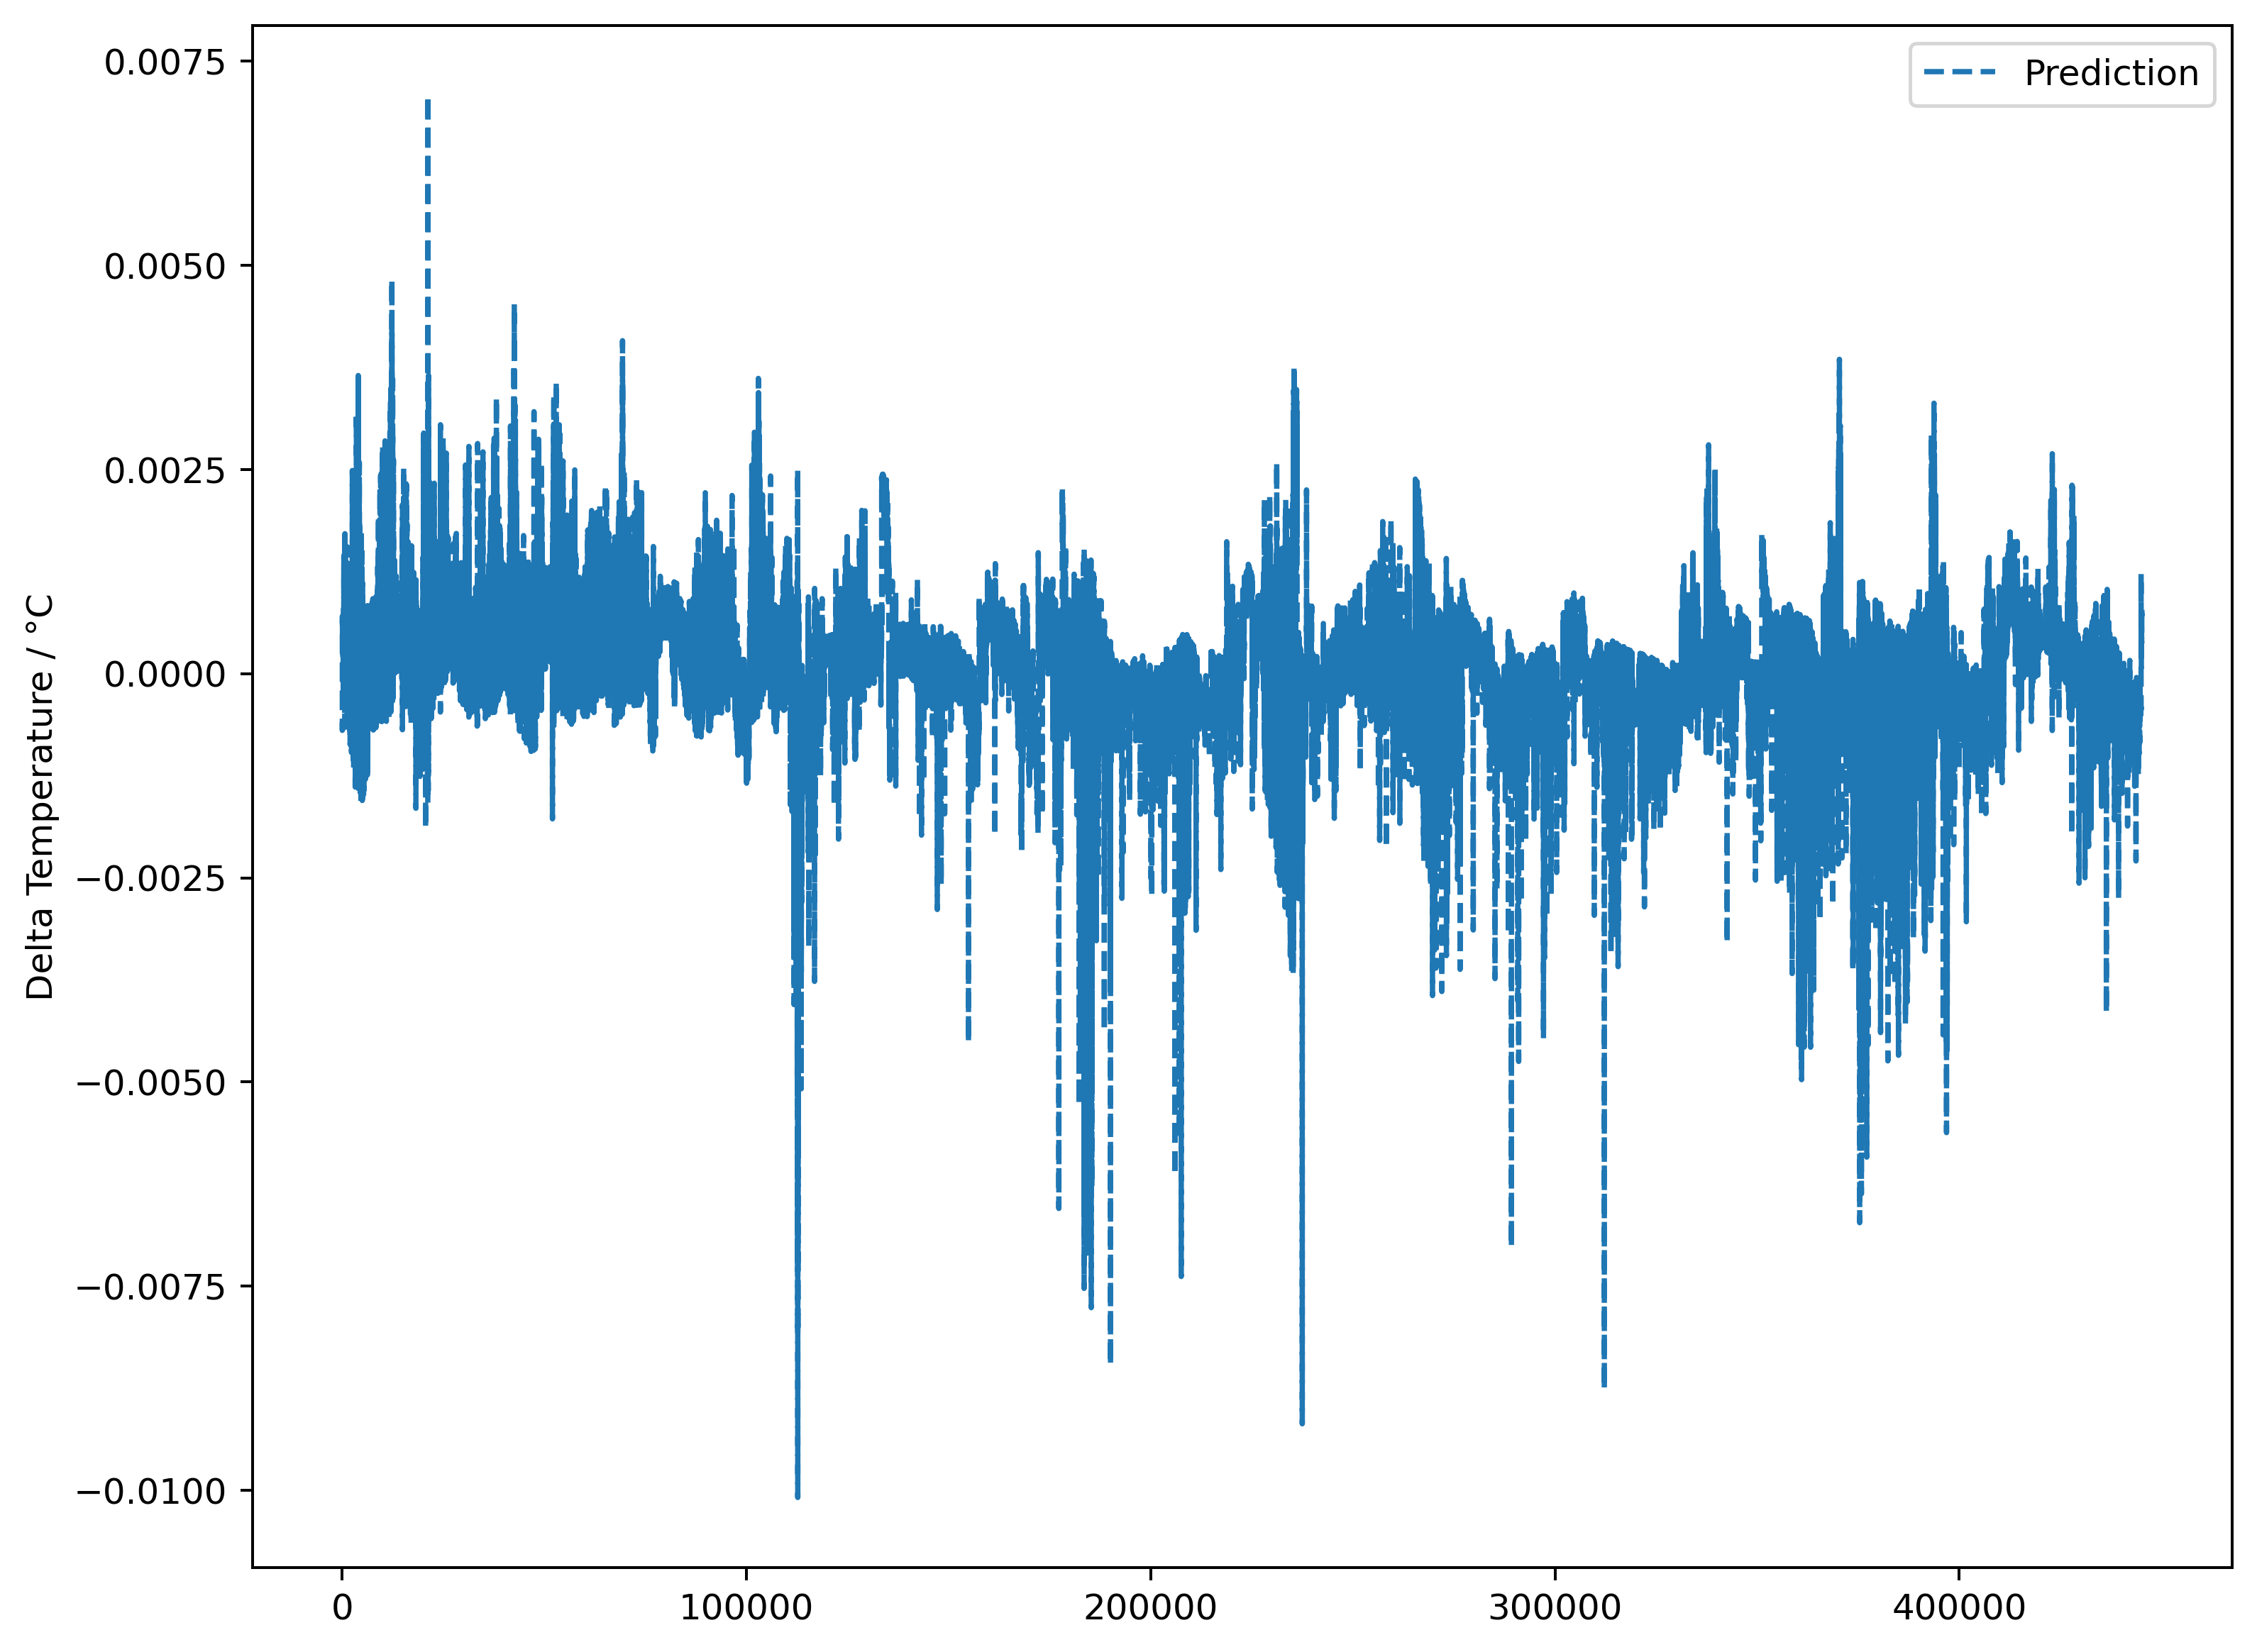

In [26]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
#plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

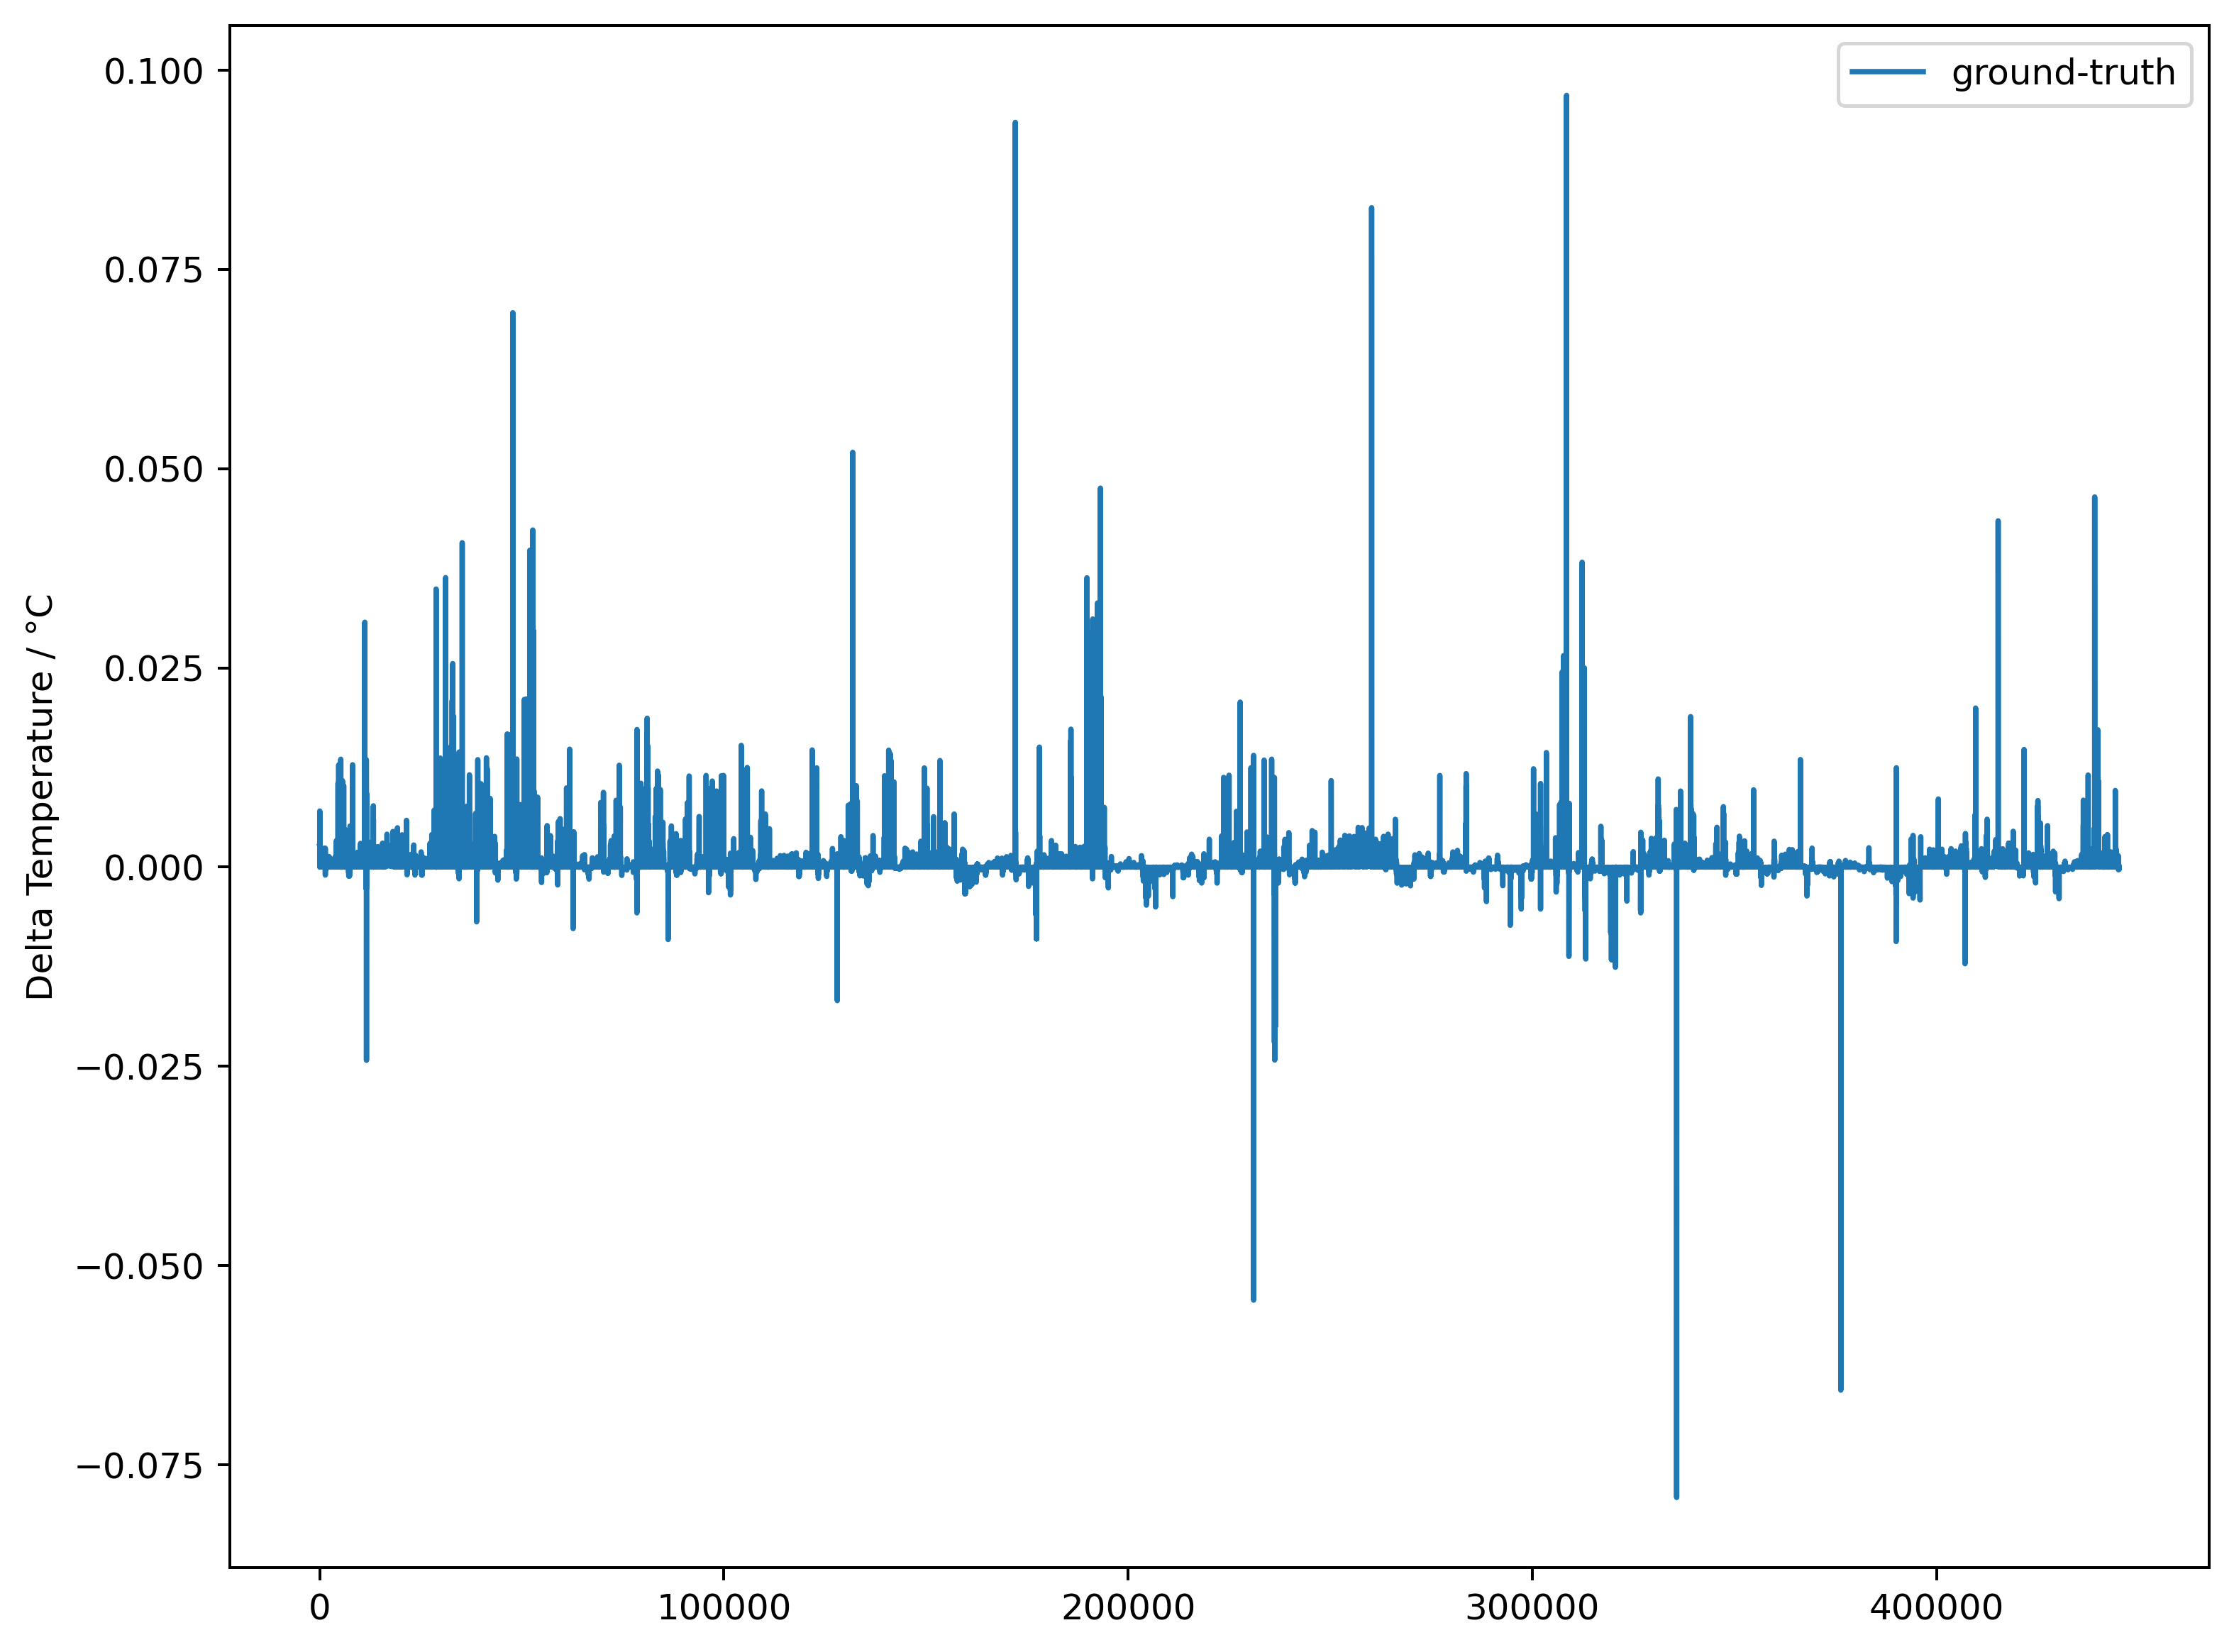

In [27]:
figure(figsize=(10, 8), dpi= 360)

#plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

In [28]:
# Take one slice of the dataset
df50=df[df['drive_id'] == 50] # dataset for index=50
true = df50[["battery_temperature"]]

true = torch.tensor(true.values).float()
true = true.numpy()

s = np.zeros((df50.shape[0],1))
s[0] = true[0]

df_xx = df50[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
df_yy = df50[["deltaTemp"]]

df_xx_tensor = (torch.tensor(df_xx.values)).float()
df_yy_tensor = torch.tensor(df_yy.values).float()


MSE: 0.0032725667395874436


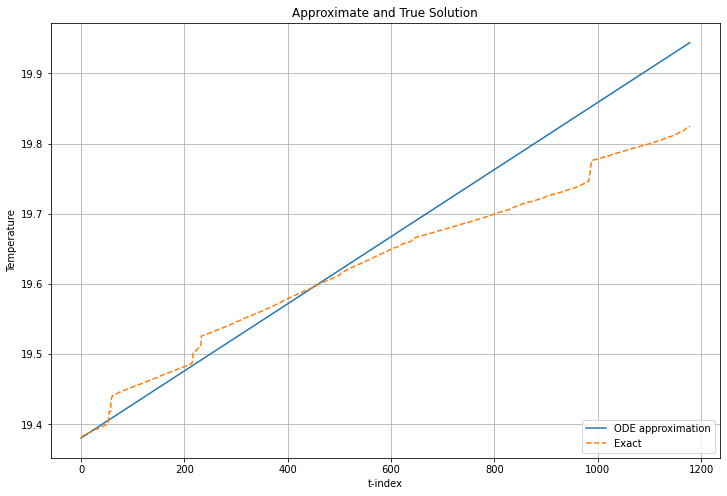

In [29]:
# Forward Euler Method for a given fixed initial conditions
for i in range(0, df50.shape[0] - 1):
    pred = model(df_xx_tensor[0].cuda())
    pred = pred.detach().cpu().numpy()
    s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))
mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

MSE: 0.013834104274015425


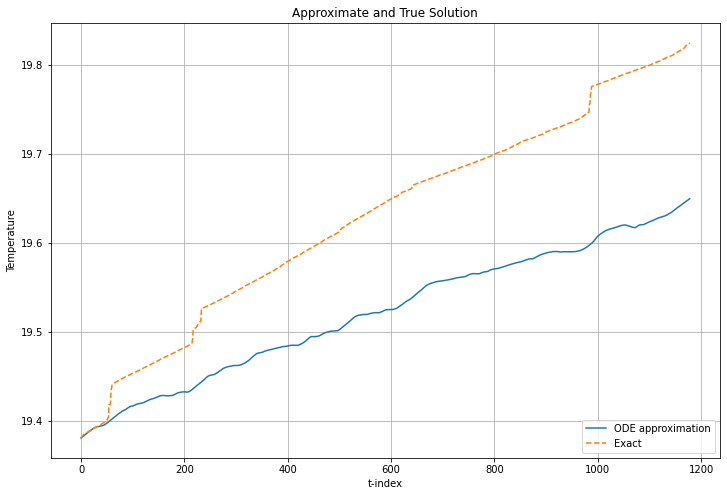

In [30]:
# Forward Euler method with updated T from data at each iteration
for i in range(0, df50.shape[0] - 1):
    pred = model(df_xx_tensor[i].cuda())
    pred = pred.detach().cpu().numpy()
    s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))
mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()



<class 'torch.Tensor'>
tensor(19.3806)
MSE: 0.012664643523987508


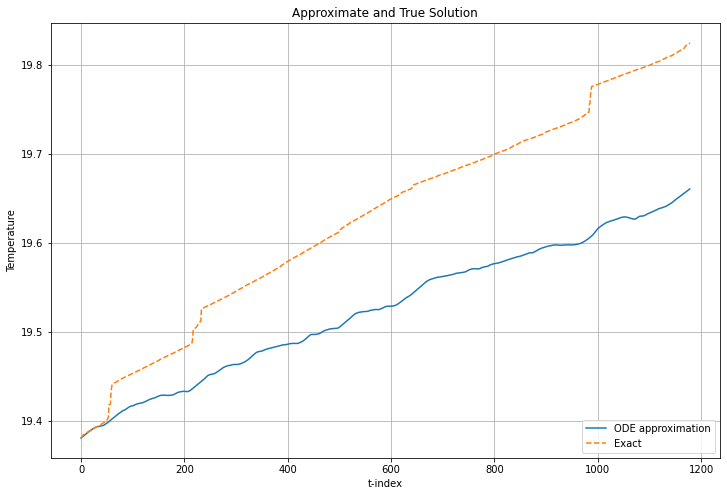

In [31]:
# Forward Euler method with updated T from model at each iteration

input = df_xx_tensor[0]
print(type(input))
print(input[4])

for i in range(0, df50.shape[0] - 1):
      input = df_xx_tensor[i]
      input[4] = torch.tensor(s[i])
      pred = model(input.cuda())
      pred = pred.detach().cpu().numpy()
      s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))

mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()
